**If you want to test it, you can use the [website](https://airbnb-prediction-app.herokuapp.com/) to see some predictions **

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import FastMarkerCluster
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Data Handling

In [32]:
df = pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv', index_col='id')
listings = pd.read_csv('../input/ab-ny-august-2019/listings.csv', index_col='id')

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
df.head()

name  host_id    host_name  \
id                                                                             
2539                Clean & quiet apt home by the park     2787         John   
2595                             Skylit Midtown Castle     2845     Jennifer   
3647               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
3831                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
5022  Entire Apt: Spacious Studio/Loft by central park     7192        Laura   

     neighbourhood_group neighbourhood  latitude  longitude        room_type  \
id                                                                             
2539            Brooklyn    Kensington  40.64749  -73.97237     Private room   
2595           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
3647           Manhattan        Harlem  40.80902  -73.94190     Private room   
3831            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
5022           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

      price  minimum_nights  number_of_reviews last_review  reviews_per_month  \
id                                                                              
2539    149               1                  9  2018-10-19               0.21   
2595    225               1                 45  2019-05-21               0.38   
3647    150               3                  0         NaN                NaN   
3831     89               1                270  2019-07-05               4.64   
5022     80              10                  9  2018-11-19               0.10   

      calculated_host_listings_count  availability_365  
id                                                      
2539                               6               365  
2595                               2               355  
3647                               1               365  
3831                               1               194  
5022                               1                 0

In [34]:
listings.head()

listing_url       scrape_id last_scraped  \
id                                                                     
2595  https://www.airbnb.com/rooms/2595  20190806030549   2019-08-07   
3647  https://www.airbnb.com/rooms/3647  20190806030549   2019-08-06   
3831  https://www.airbnb.com/rooms/3831  20190806030549   2019-08-06   
5022  https://www.airbnb.com/rooms/5022  20190806030549   2019-08-06   
5099  https://www.airbnb.com/rooms/5099  20190806030549   2019-08-06   

                                                  name  \
id                                                       
2595                             Skylit Midtown Castle   
3647               THE VILLAGE OF HARLEM....NEW YORK !   
3831                   Cozy Entire Floor of Brownstone   
5022  Entire Apt: Spacious Studio/Loft by central park   
5099         Large Cozy 1 BR Apartment In Midtown East   

                                                summary  \
id                                                        
2595  Find your romantic getaway to this beautiful, ...   
3647                                                NaN   
3831  Urban retreat: enjoy 500 s.f. floor in 1899 br...   
5022                                                NaN   
5099  My large 1 bedroom apartment is true New York ...   

                                                  space  \
id                                                        
2595  - Spacious (500+ft²), immaculate and nicely fu...   
3647  WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...   
3831  Greetings!      We own a double-duplex brownst...   
5022  Loft apartment with high ceiling and wood floo...   
5099  I have a large 1 bedroom apartment centrally l...   

                                            description experiences_offered  \
id                                                                            
2595  Find your romantic getaway to this beautiful, ...                none   
3647  WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...                none   
3831  Urban retreat: enjoy 500 s.f. floor in 1899 br...                none   
5022  Loft apartment with high ceiling and wood floo...                none   
5099  My large 1 bedroom apartment is true New York ...                none   

                                  neighborhood_overview  \
id                                                        
2595  Centrally located in the heart of Manhattan ju...   
3647                                                NaN   
3831  Just the right mix of urban center and local n...   
5022                                                NaN   
5099  My neighborhood in Midtown East is called Murr...   

                                                  notes  ... instant_bookable  \
id                                                       ...                    
2595                                                NaN  ...                f   
3647                                                NaN  ...                f   
3831                                                NaN  ...                f   
5022                                                NaN  ...                f   
5099  Read My Full Listing For All Information. New ...  ...                f   

     is_business_travel_ready          cancellation_policy  \
id                                                           
2595                        f  strict_14_with_grace_period   
3647                        f  strict_14_with_grace_period   
3831                        f                     moderate   
5022                        f  strict_14_with_grace_period   
5099                        f  strict_14_with_grace_period   

     require_guest_profile_picture  require_guest_phone_verification  \
id                                                                     
2595                             t                                 t   
3647                             t                                 t   
3831                         

<!-- Let's merge the datasets to use the additional information comes from the listings.csv -->

In [35]:
target_columns = ["property_type", "accommodates",  "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "host_is_superhost", "host_response_time", "host_response_rate",  'bathrooms', 'bedrooms', 'beds']
data = pd.merge(df, listings[target_columns], on='id', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month         

In [36]:
data.isnull().sum()

name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
property_type                      3371
accommodates                       3371
review_scores_value               12629
review_scores_cleanliness         12594
review_scores_location            12631
review_scores_accuracy            12611
review_scores_communication       12605
review_scores_checkin             12627
review_scores_rating              12573
maximum_nights                     3371


In [37]:
data.describe()

host_id      latitude     longitude         price  minimum_nights  \
count  4.889500e+04  48895.000000  48895.000000  48895.000000    48895.000000   
mean   6.762001e+07     40.728949    -73.952170    152.720687        7.029962   
std    7.861097e+07      0.054530      0.046157    240.154170       20.510550   
min    2.438000e+03     40.499790    -74.244420      0.000000        1.000000   
25%    7.822033e+06     40.690100    -73.983070     69.000000        1.000000   
50%    3.079382e+07     40.723070    -73.955680    106.000000        3.000000   
75%    1.074344e+08     40.763115    -73.936275    175.000000        5.000000   
max    2.743213e+08     40.913060    -73.712990  10000.000000     1250.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       48895.000000       38843.000000                    48895.000000   
mean           23.274466           1.373221                        7.143982   
std            44.550582           1.680442                       32.952519   
min             0.000000           0.010000                        1.000000   
25%             1.000000           0.190000                        1.000000   
50%             5.000000           0.720000                        1.000000   
75%            24.000000           2.020000                        2.000000   
max           629.000000          58.500000                      327.000000   

       availability_365  accommodates  ...  review_scores_cleanliness  \
count      48895.000000  45524.000000  ...               36301.000000   
mean         112.781327      2.823851  ...                   9.286025   
std          131.622289      1.843100  ...                   1.070661   
min            0.000000      1.000000  ...                   2.000000   
25%            0.000000      2.000000  ...                   9.000000   
50%           45.000000      2.000000  ...                  10.000000   
75%          227.000000      4.000000  ...                  10.000000   
max          365.000000     19.000000  ...                  10.000000   

       review_scores_location  review_scores_accuracy  \
count            36264.000000            36284.000000   
mean                 9.569683                9.630057   
std                  0.754216                0.827604   
min                  2.000000                2.000000   
25%                  9.000000                9.000000   
50%                 10.000000               10.000000   
75%                 10.000000               10.000000   
max                 10.000000               10.000000   

       review_scores_communication  review_scores_checkin  \
count                 36290.000000           36268.000000   
mean                      9.763544               9.754632   
std                       0.713807               0.706209   
min                       2.000000               2.000000   
25%                      10.000000              10.000000   
50%                      10.000000              10.000000   
75%                      10.000000              10.000000   
max                      10.000000              10.000000   

       review_scores_rating  maximum_nights     bathrooms      bedrooms  \
count          36322.000000    4.552400e+04  45470.000000  45503.000000   
mean              94.011150    4.869897e+04      1.141115      1.166297   
std                8.434653    1.006577e+07      0.427321      0.732174   
min               20.000000    1.000000e+00      0.000000      0.000000   
25%               92.000000    2.900000e+01      1.000000      1.000000   
50%               96.000000    1.111000e+03      1.000000      1.000000   
75%              100.000000    1.125000e+03      1.000000      1.000000   
max              100.000000    2.147484e+09     15.500000     14.000000   

               beds  
count  45487.000000  
mean       1.536989  
std        1.097193  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        2.00000

### Handling Missing Data

1.   The **weekly price** and the **monthly price** columns are mostly missing. We can drop it. 
2.   We can fullfill the **reviews_per_month** just dividing **number reviews** by 12.

3. Since there is not much standart deviation we can fullfill the **review_scores** with it's mean.

4. We can fullfill the **response time** with the mean value

5. The other object columns can be filled the most occurring element in that column.

6. Badrooms, Bed, Bathroom can be replaced with it's mean

In [38]:
data['reviews_per_month'] = data['number_of_reviews'] / 12

reviews = ['review_scores_value', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_checkin', 'review_scores_rating']
for i in reviews:
  data[i].fillna(data[i].mean(), inplace=True)

data['accommodates'].fillna(data['accommodates'].mean(), inplace=True)
data['maximum_nights'].fillna(data['maximum_nights'].mean(), inplace=True)

data.drop(columns=['last_review'], inplace=True)

cat_columns = ['host_response_time', 'host_response_rate', 'property_type', 'host_is_superhost']

for i in cat_columns:
  data[i].fillna(data[i].value_counts().idxmax(), inplace=True)

a = ['bathrooms', 'beds', 'bedrooms']
for i in a:
  data[i].fillna(data[i].mean(), inplace=True)


data.isnull().sum()


name                              16
host_id                            0
host_name                         21
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
property_type                      0
accommodates                       0
review_scores_value                0
review_scores_cleanliness          0
review_scores_location             0
review_scores_accuracy             0
review_scores_communication        0
review_scores_checkin              0
review_scores_rating               0
maximum_nights                     0
host_is_superhost                  0
host_response_time                 0
host_response_rate                 0
b

### Handling Outliers


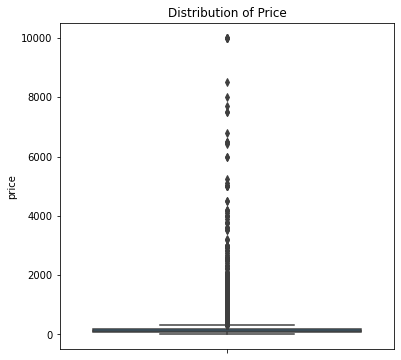

In [39]:
plt.figure(figsize=(6,6))
sns.boxplot(y=data['price'])
plt.title("Distribution of Price")
plt.show()

There are so many outlier in the price. Let's drop them.

In [40]:
mean = data['price'].mean()
std = data['price'].std()
upper_limit = mean + 3 * std
data = data[data['price'] <= upper_limit]

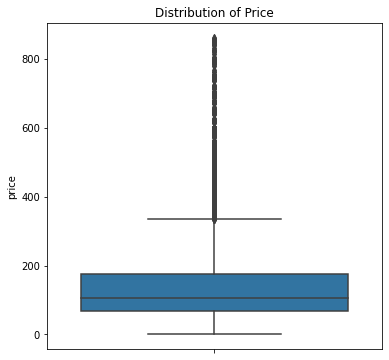

In [41]:
plt.figure(figsize=(6,6))
sns.boxplot(y=data['price'])
plt.title("Distribution of Price")
plt.show()

In [42]:
data.head()

name  host_id    host_name  \
id                                                                             
2539                Clean & quiet apt home by the park     2787         John   
2595                             Skylit Midtown Castle     2845     Jennifer   
3647               THE VILLAGE OF HARLEM....NEW YORK !     4632    Elisabeth   
3831                   Cozy Entire Floor of Brownstone     4869  LisaRoxanne   
5022  Entire Apt: Spacious Studio/Loft by central park     7192        Laura   

     neighbourhood_group neighbourhood  latitude  longitude        room_type  \
id                                                                             
2539            Brooklyn    Kensington  40.64749  -73.97237     Private room   
2595           Manhattan       Midtown  40.75362  -73.98377  Entire home/apt   
3647           Manhattan        Harlem  40.80902  -73.94190     Private room   
3831            Brooklyn  Clinton Hill  40.68514  -73.95976  Entire home/apt   
5022           Manhattan   East Harlem  40.79851  -73.94399  Entire home/apt   

      price  minimum_nights  ...  review_scores_communication  \
id                           ...                                
2539    149               1  ...                     9.763544   
2595    225               1  ...                    10.000000   
3647    150               3  ...                     9.763544   
3831     89               1  ...                     9.000000   
5022     80              10  ...                    10.000000   

      review_scores_checkin  review_scores_rating  maximum_nights  \
id                                                                  
2539               9.754632              94.01115    48698.973355   
2595              10.000000              95.00000     1125.000000   
3647               9.754632              94.01115        7.000000   
3831              10.000000              90.00000      730.000000   
5022              10.000000              93.00000      120.000000   

     host_is_superhost  host_response_time  host_response_rate  bathrooms  \
id                                                                          
2539                 f      within an hour                100%   1.141115   
2595                 f  within a few hours                 90%   1.000000   
3647                 f        within a day                100%   1.000000   
3831                 f      within an hour                 90%   1.000000   
5022                 f      within an hour                100%   1.000000   

      bedrooms      beds  
id                        
2539  1.166297  1.536989  
2595  0.000000  1.000000  
3647  1.000000  1.000000  
3831  1.000000  4.000000  
5022  1.166297  1.000000  

[5 rows x 30 columns]

**What's Done**


1.   Handling the Missing Values
2.   Dropping the Outliers



## DATA EXPLORATION

In this section what we will do:

*   Visualization of Some Columns
*   Understand if There is a Correlation Between tthe Variables
*   Understand the behaviour the data


### Neighbourhood Distribution

Text(0.5, 1.0, 'Numbers in Each Neigbourhoods')

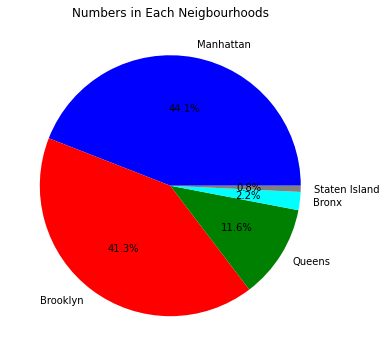

In [43]:
plt.figure(figsize=(6,6))
numbers = data['neighbourhood_group'].value_counts()
plt.pie(numbers.values, labels=numbers.index, colors=['b', 'r', 'g', 'cyan', 'gray'], autopct='%1.1f%%')
plt.title('Numbers in Each Neigbourhoods')

Manhattan has the most house. Brooklyn follows Manhattan with a big portion. Mostly the rooms are distributed in Brooklyn and Manhattan

### Room Type Distribution

Text(0.5, 1.0, 'Numbers in Each Room Types')

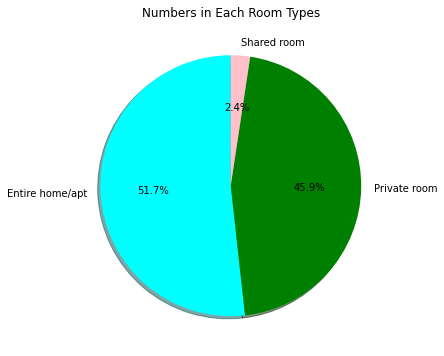

In [44]:
plt.figure(figsize=(6,6))
numbers = data['room_type'].value_counts()
plt.pie(numbers.values, labels=numbers.index, colors=['cyan', 'green', 'pink'], autopct='%1.1f%%', shadow=True,startangle=90)
plt.title('Numbers in Each Room Types')

There are mostly entire home and private room. There is also a small portion in shared rooms.

### Distribution of room types in the Map.

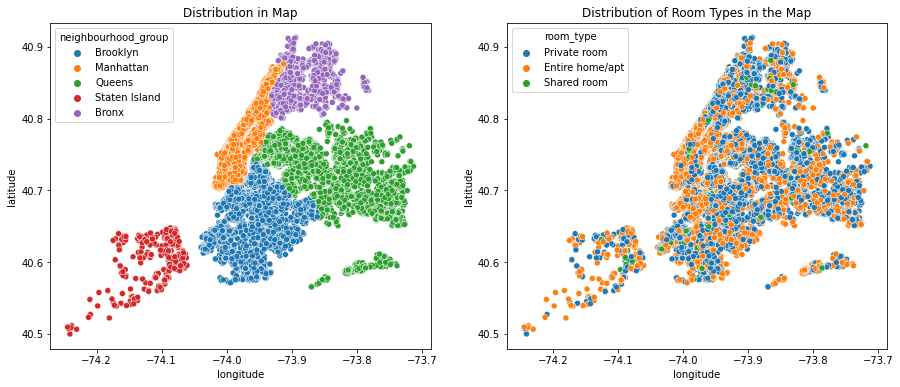

In [45]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
sns.scatterplot(data['longitude'], data['latitude'], hue=data['neighbourhood_group'], ax=ax1)
ax1.set_title('Distribution in Map')

ax2 = fig.add_subplot(122)
sns.scatterplot(data['longitude'], data['latitude'], hue=data['room_type'], ax=ax2)
ax2.set_title('Distribution of Room Types in the Map')

plt.show()

### Distribution of Room Types in Each Neighbourhood

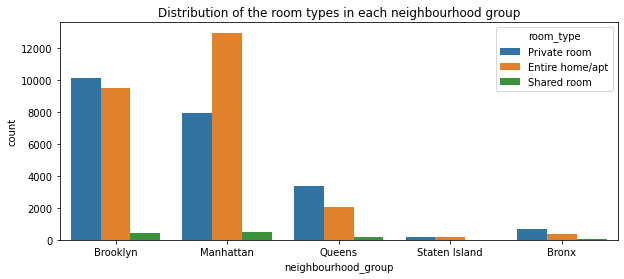

In [46]:
plt.figure(figsize=(10,4))
sns.countplot(data['neighbourhood_group'], hue=data['room_type'])
plt.title('Distribution of the room types in each neighbourhood group')
plt.show()

Manhattan has the most room. Mostly the room types in Manhattan is Entire Home which is an interesting part. Because in the other neighbourhoods, the private room number is higher than the entire home.

In [47]:
### Price Distribution in Each Neighbourhood

Text(0, 0.5, 'Price')

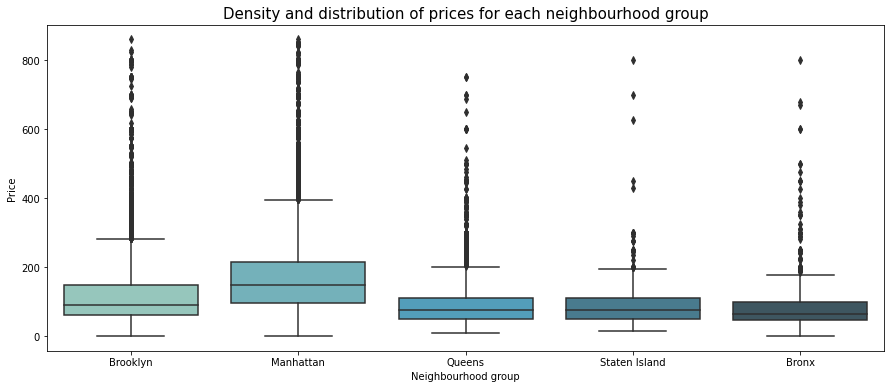

In [48]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='neighbourhood_group', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each neighbourhood group', fontsize=15)
plt.xlabel('Neighbourhood group')
plt.ylabel("Price")

It can be seen that mean of prices in **Manhattan** are higher than the rest. Let' see which room is the most expensive and which room type is the cheapest.

### Price Distribution in Each Room Type

Text(0, 0.5, 'Price')

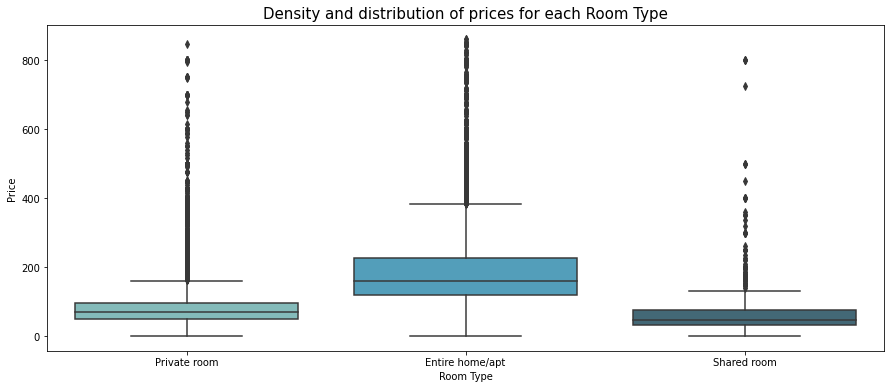

In [49]:
plt.figure(figsize=(15,6))
sns.boxplot(data=data, x='room_type', y='price', palette='GnBu_d')
plt.title('Density and distribution of prices for each Room Type', fontsize=15)
plt.xlabel('Room Type')
plt.ylabel("Price")

It is not an unusual condition. It makes sense that entire home is more expensive than other and it also makes sense that private room is more expensive than the shared room.

One of the reason **Manhattan is more expensive than others** might be the **room type**. We already know that **entire homes** are **more expensive** than others. Manhattan has the most entire home room type.

### Distribution of the Rooms in the Map

Credits to:  [Erik Bruin](https://www.kaggle.com/erikbruin/airbnb-the-amsterdam-story-with-interactive-maps)

In [50]:
latitudes = np.array(data['latitude'])
longitudes = np.array(data['longitude'])
la_mean = latitudes.mean()
lo_mean = longitudes.mean()
locations = list(zip(latitudes, longitudes))

m = folium.Map(location=[la_mean, lo_mean], zoom_start= 11.5)
FastMarkerCluster(data=locations).add_to(m)
m

### Distribution of the Accommodates

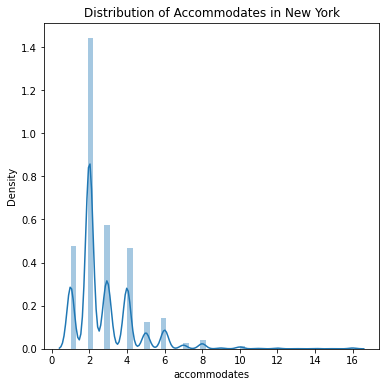

In [51]:
plt.figure(figsize=(6, 6))
sns.distplot(data['accommodates'])
plt.title('Distribution of Accommodates in New York')
plt.show()

Mostly houses are 2 accommodates

### Distribution of the Price

Text(0.5, 1.0, 'Distribution of price')

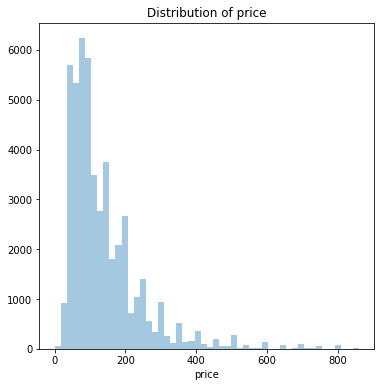

In [52]:
plt.figure(figsize=(6, 6))
sns.distplot(data['price'], kde=False)
plt.title('Distribution of price')

It can be seen that prices are mostly around between 100 and 200 dollars.
Price data is right skewed. Let's plot the Price Distribution in Logarithm to see what happens

Text(0.5, 1.0, 'Distribution of price in Logarithm')

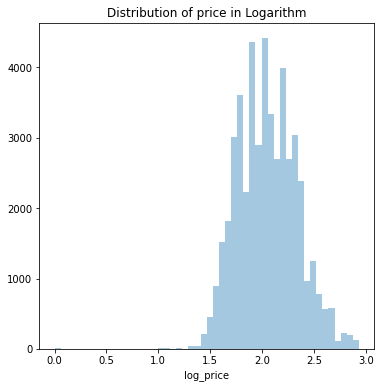

In [53]:
data['log_price'] = np.log10(data['price'] + 1)
plt.figure(figsize=(6, 6))
sns.distplot(data['log_price'], kde=False)
plt.title('Distribution of price in Logarithm')

When we plot the price in logarithmic case, the distribution likes the normal distribution. The skewed data turned to like a normal distribution. 

### Most Expensive and The Cheapest Neighbourhoods

In [54]:
a = data.groupby('neighbourhood')['price'].mean().sort_values(ascending=True).head(20)
d = data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(20)

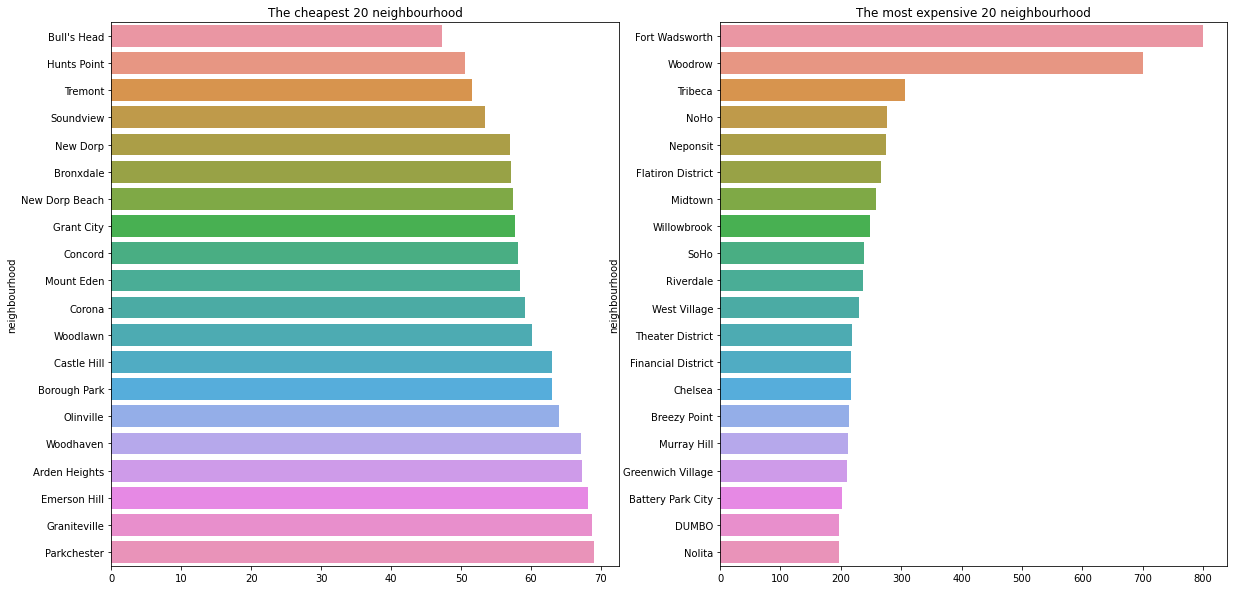

In [55]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
sns.barplot(y=a.index, x=a.values, ax=ax1)
ax1.set_title('The cheapest 20 neighbourhood')

ax2 = fig.add_subplot(122)
sns.barplot(y=d.index, x=d.values, ax=ax2)
ax2.set_title('The most expensive 20 neighbourhood')
plt.show()

### Distribution of the Reviews

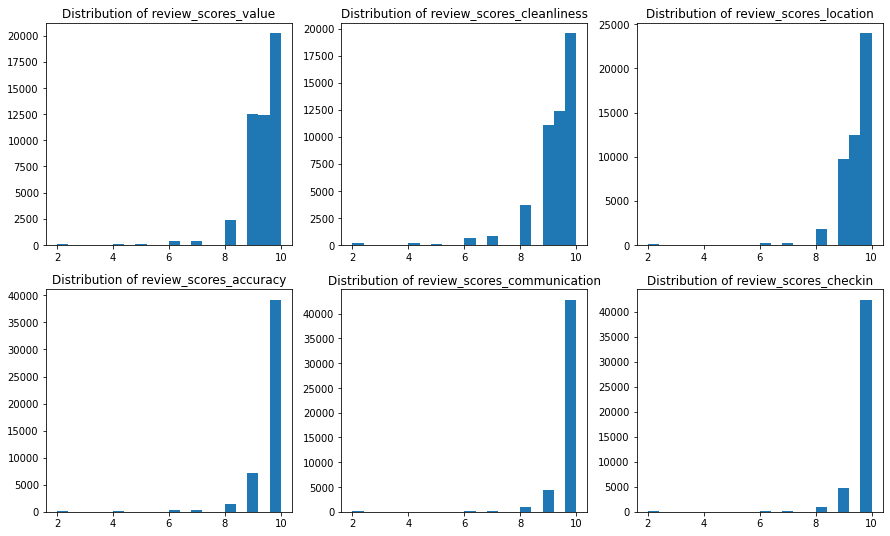

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))

for ax, name in zip(axes.flatten(), reviews):
  ax.hist(data[name], bins=20)
  ax.set_title(f"Distribution of {name}")

plt.show()



Reviews Scores are mostly around 8 - 10. Since the most of the houses review scores are high, it might not be a good feature for price prediction. But that is just an assumption. We will see if there is a correlation between review scores and the price after a few cells.

### Distribution of the Rooms

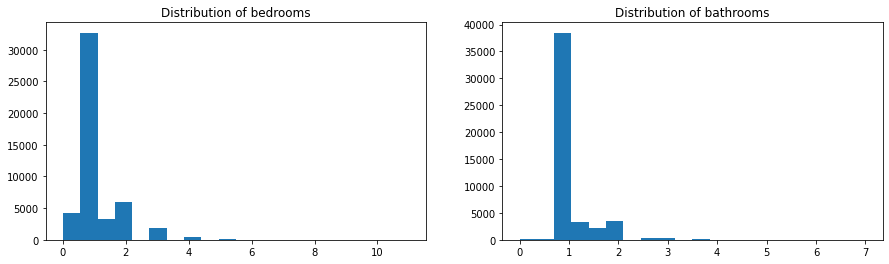

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

rooms = ['bedrooms', 'bathrooms']

for ax, name in zip(axes.flatten(), rooms):
  ax.hist(data[name], bins=20)
  ax.set_title(f"Distribution of {name}")

plt.show()


The distribution builds up around 1. This means in an average home there is one room and 1 bathroom. 

### Distribution of Availability

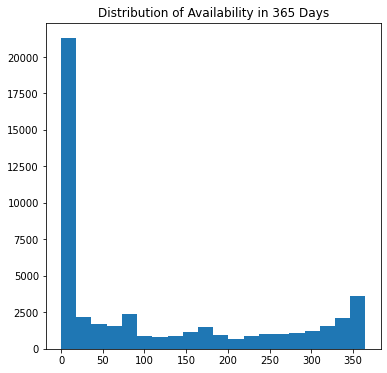

In [58]:
plt.figure(figsize=(6,6))

plt.hist(data['availability_365'], bins=20)

plt.title("Distribution of Availability in 365 Days")

plt.show()

There are every kind of information in our dataset. There is 365 day, there is 0 day also. The data is right skewed. 

### Correlation Map Between Numerical Variables

<AxesSubplot:>

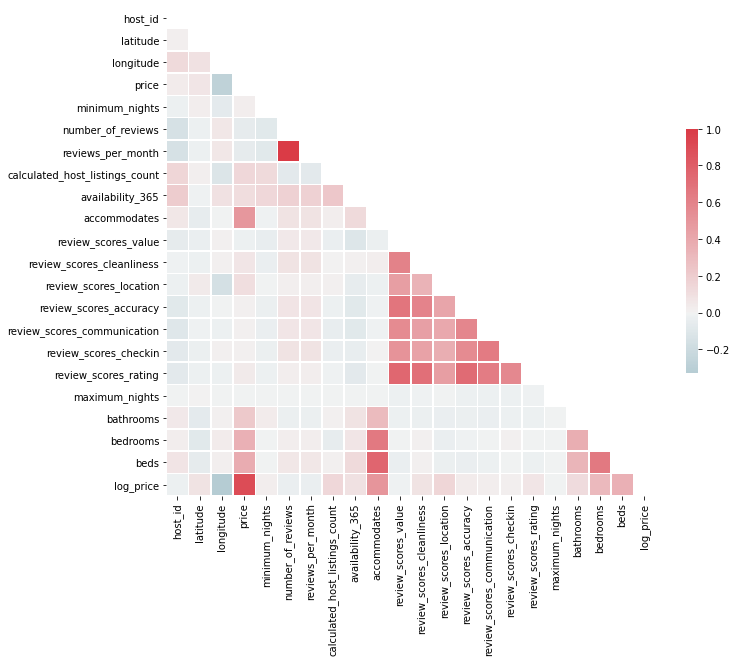

In [59]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

It can be seen that there is a strong correlation in the reviews part. But there is no strong correlation between reviews scores and prices. Because most of the host's review scores are between 8 - 10. However, there is a strong correlation between (bedrooms, bathrooms and bed) and price. 

### Correlation Graphics Between Each Column and the Price

In [60]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# newdf = data.select_dtypes(include=numerics)
# nrows = int(len(newdf.columns) / 3) + 1
# fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(24, 6*nrows))
# fig.subplots_adjust(hspace=0.5)

# for ax, name in zip(axes.flatten(), newdf.columns):
  
#   sns.regplot(x=name, y='price', data=newdf, ax=ax)
#   ax.set_title(f"Correlation between {name} and the price")

# plt.show()

There is a relationships between **accommodates** and the **price.** It can be seen easily above 2 parts. It is natural to have that kind of correlation. Because, when the number of people that can stay in a place, the price will increase naturally. And the there is a correlation between **some of the review scores and the prices.** There is also a correlation between **bathrooms, bathrooms and bed, to price.** There is also a **negative correlation between distance to nearest station and the price.** When the distance increases, the price decreases. We already know that, the shorter distance is an important feature for the houses nowadays.

### Distrbution of None Numerical Columns

In [61]:
a = data.groupby(['neighbourhood_group', 'neighbourhood'])['price'].mean().sort_values(ascending=False).head(50)
a = a.reset_index()
a

neighbourhood_group       neighbourhood       price
0        Staten Island      Fort Wadsworth  800.000000
1        Staten Island             Woodrow  700.000000
2            Manhattan             Tribeca  305.792453
3            Manhattan                NoHo  276.246753
4               Queens            Neponsit  274.666667
5            Manhattan   Flatiron District  266.053333
6            Manhattan             Midtown  258.347682
7        Staten Island         Willowbrook  249.000000
8            Manhattan                SoHo  238.526316
9                Bronx           Riverdale  236.300000
10           Manhattan        West Village  230.453691
11           Manhattan    Theater District  218.576512
12           Manhattan  Financial District  216.603518
13           Manhattan             Chelsea  216.020183
14              Queens        Breezy Point  213.333333
15           Manhattan         Murray Hill  212.243243
16           Manhattan   Greenwich Village  211.013089
17           Manhattan   Battery Park City  201.477612
18            Brooklyn               DUMBO  196.305556
19           Manhattan              Nolita  196.140000
20           Manhattan      Hell's Kitchen  193.796191
21           Manhattan            Gramercy  190.578788
22           Manhattan            Kips Bay  189.768240
23            Brooklyn    Brooklyn Heights  189.410596
24            Brooklyn         Cobble Hill  187.948454
25            Brooklyn        Vinegar Hill  187.176471
26              Queens     Jamaica Estates  182.947368
27            Brooklyn          Mill Basin  179.750000
28           Manhattan        Civic Center  177.078431
29           Manhattan        Little Italy  173.285714
30           Manhattan        East Village  172.453754
31           Manhattan     Upper West Side  171.888257
32              Queens        Belle Harbor  171.500000
33            Brooklyn     Carroll Gardens  170.659483
34       Staten Island           Todt Hill  169.000000
35           Manhattan     Upper East Side  168.312500
36            Brooklyn         Boerum Hill  167.291429
37            Brooklyn          Park Slope  163.676000
38           Manhattan     Lower East Side  159.732597
39       Staten Island         Grymes Hill  159.142857
40       Staten Island     Lighthouse Hill  157.500000
41           Manhattan           Chinatown  155.549180
42               Bronx      Spuyten Duyvil  154.750000
43              Queens             Arverne  154.302632
44       Staten Island         Shore Acres  152.714286
45            Brooklyn           Navy Yard  151.642857
46            Brooklyn             Gowanus  150.575510
47            Brooklyn   Downtown Brooklyn  150.349398
48            Brooklyn         Fort Greene  147.480493
49            Brooklyn         South Slope  146.725352

Credits to: [Devakumar kp](https://www.kaggle.com/imdevskp/nyc-airbnb-open-data-eda)

[]

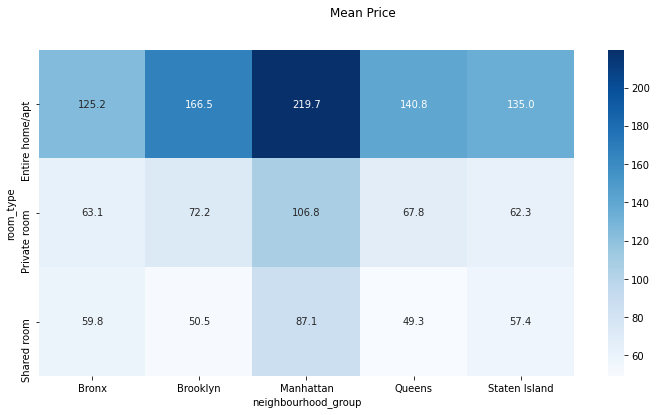

In [62]:
plt.figure(figsize=(12, 6))
df_pivot = data.pivot_table(values='price', index='room_type', columns='neighbourhood_group', aggfunc='mean')
sns.heatmap(df_pivot, annot=True, fmt='.1f', cmap='Blues')
plt.suptitle('Mean Price')
plt.plot()

**It can be seen that in every neighbourhood price of Entire Home > Private Room > Shared Room.**

In [63]:
a = data.groupby(['neighbourhood_group', 'property_type'])['price'].mean().sort_values(ascending=False).head(20)
a = a.reset_index()
a

neighbourhood_group       property_type       price
0            Manhattan          Lighthouse  750.000000
1            Manhattan               Villa  470.000000
2            Manhattan              Resort  465.031746
3               Queens           Houseboat  365.000000
4            Manhattan               Cabin  300.000000
5                Bronx               Villa  299.000000
6            Manhattan          Aparthotel  279.357143
7            Manhattan                Loft  277.136951
8            Manhattan      Boutique hotel  263.470000
9            Manhattan  Serviced apartment  250.229226
10           Manhattan         Condominium  235.207337
11           Manhattan           Townhouse  228.123223
12            Brooklyn      Boutique hotel  214.357143
13              Queens                Tent  213.333333
14           Manhattan               House  210.949640
15           Manhattan               Other  203.017544
16           Manhattan               Hotel  201.898477
17            Brooklyn             Cottage  196.666667
18           Manhattan          Guesthouse  193.000000
19           Manhattan                Yurt  188.000000

**Villa's, Boutique Hotel are the common property types which are expensive in every Neighbourhood Group.**

## MACHINE LEARNING

Our purpose is predict the price based on the given dataset. Since price is a continous variable we need to do a regression task. Therefore, we will use the Regression models of the traditional models such as KNN, SVM. 

We are not after accuracy, because we are doing a regression task, not a classification task. Our main metric will be mean squared error and we will try to minimize it with some methods such as hyperparameter tuning. 

Almost in every model we have sections such as




Before Hyperparameter Tuning( We are trying model with default 



*   Train model with the default parameters

*   See the error and r2 score

*   Compare with other models and results

After Hyperparameter Tuning



*   Determine the parameter grid
*   Do a gridsearch to get best model parameters.
* Compare with the default model and other models.





### DATA PREPARATION

#### Dropping Unnecessary Columns

In [64]:
data = data[data.price > 0]
data.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'property_type',
       'accommodates', 'review_scores_value', 'review_scores_cleanliness',
       'review_scores_location', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_checkin',
       'review_scores_rating', 'maximum_nights', 'host_is_superhost',
       'host_response_time', 'host_response_rate', 'bathrooms', 'bedrooms',
       'beds', 'log_price'],
      dtype='object')

We will not need name, host_id, host_name. Because those columns does not affect price.

In [65]:
data.drop(columns=['name', 'host_id', 'host_name', 'reviews_per_month'], inplace=True)

#### ENCODING

In [66]:
data.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
property_type                      object
accommodates                      float64
review_scores_value               float64
review_scores_cleanliness         float64
review_scores_location            float64
review_scores_accuracy            float64
review_scores_communication       float64
review_scores_checkin             float64
review_scores_rating              float64
maximum_nights                    float64
host_is_superhost                  object
host_response_time                 object
host_response_rate                 object
bathrooms                         

As we can see above the neighbourhood_group, neighbourhood, room type, host_is_superhost, host_response time and host_response rate are all categorical columns. Let's encode them, se we can use them in training.

In [67]:
from sklearn.preprocessing import LabelEncoder

categorical = data.select_dtypes(include=['object']).columns

for i in categorical:
  data[i] = LabelEncoder().fit_transform(data[i])


data.dtypes

neighbourhood_group                 int64
neighbourhood                       int64
latitude                          float64
longitude                         float64
room_type                           int64
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
availability_365                    int64
property_type                       int64
accommodates                      float64
review_scores_value               float64
review_scores_cleanliness         float64
review_scores_location            float64
review_scores_accuracy            float64
review_scores_communication       float64
review_scores_checkin             float64
review_scores_rating              float64
maximum_nights                    float64
host_is_superhost                   int64
host_response_time                  int64
host_response_rate                  int64
bathrooms                         

In [68]:
data = data.reset_index(drop=True)

data.head()

neighbourhood_group  neighbourhood  latitude  longitude  room_type  price  \
0                    1            108  40.64749  -73.97237          1    149   
1                    2            127  40.75362  -73.98377          0    225   
2                    2             94  40.80902  -73.94190          1    150   
3                    1             41  40.68514  -73.95976          0     89   
4                    2             61  40.79851  -73.94399          0     80   

   minimum_nights  number_of_reviews  calculated_host_listings_count  \
0               1                  9                               6   
1               1                 45                               2   
2               3                  0                               1   
3               1                270                               1   
4              10                  9                               1   

   availability_365  ...  review_scores_checkin  review_scores_rating  \
0               365  ...               9.754632              94.01115   
1               355  ...              10.000000              95.00000   
2               365  ...               9.754632              94.01115   
3               194  ...              10.000000              90.00000   
4                 0  ...              10.000000              93.00000   

   maximum_nights  host_is_superhost  host_response_time  host_response_rate  \
0    48698.973355                  0                   3                   2   
1     1125.000000                  0                   2                  67   
2        7.000000                  0                   1                   2   
3      730.000000                  0                   3                  67   
4      120.000000                  0                   3                   2   

   bathrooms  bedrooms      beds  log_price  
0   1.141115  1.166297  1.536989   2.176091  
1   1.000000  0.000000  1.000000   2.354108  
2   1.000000  1.000000  1.000000   2.178977  
3   1.000000  1.000000  4.000000   1.954243  
4   1.000000  1.166297  1.000000   1.908485  

[5 rows x 27 columns]

Let's determine train data and target column. After that scale the data.
Split the data as:


*   Training: 80%
*   Test : 20%

In [69]:
data.drop(columns=['log_price'], inplace=True)

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = data.drop(columns=['price'])
y = data['price']

columns = X.columns
scaler = StandardScaler()
X[columns] = scaler.fit_transform(X[columns])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"There are {X_train.shape[0]} traning data")
print(f"There are {X_test.shape[0]} test data")


X.head()

There are 38796 traning data
There are 9700 test data


neighbourhood_group  neighbourhood  latitude  longitude  room_type  \
0            -0.914773       0.014738 -1.491170  -0.441597   0.905201   
1             0.441930       0.291191  0.452418  -0.688596  -0.928033   
2             0.441930      -0.188964  1.466974   0.218584   0.905201   
3            -0.914773      -0.960122 -0.801675  -0.168381  -0.928033   
4             0.441930      -0.669119  1.274501   0.173301  -0.928033   

   minimum_nights  number_of_reviews  calculated_host_listings_count  \
0       -0.294649          -0.322196                       -0.035443   
1       -0.294649           0.483588                       -0.156399   
2       -0.196092          -0.523642                       -0.186638   
3       -0.294649           5.519735                       -0.186638   
4        0.148858          -0.322196                       -0.186638   

   availability_365  property_type  ...  review_scores_communication  \
0          1.925506      -0.462572  ...                    -0.000180   
1          1.849343      -0.462572  ...                     0.384208   
2          1.925506      -0.462572  ...                    -0.000180   
3          0.623115       1.436938  ...                    -1.241412   
4         -0.854451      -0.462572  ...                     0.384208   

   review_scores_checkin  review_scores_rating  maximum_nights  \
0              -0.000537              0.000190       -0.000033   
1               0.403665              0.136079       -0.004912   
2              -0.000537              0.000190       -0.005026   
3               0.403665             -0.551028       -0.004952   
4               0.403665             -0.138764       -0.005015   

   host_is_superhost  host_response_time  host_response_rate  bathrooms  \
0          -0.484898            0.514401           -0.451006   0.016193   
1          -0.484898           -0.877153            2.365575  -0.345316   
2          -0.484898           -2.268707           -0.451006  -0.345316   
3          -0.484898            0.514401            2.365575  -0.345316   
4          -0.484898            0.514401           -0.451006  -0.345316   

   bedrooms      beds  
0  0.010925  0.010177  
1 -1.686890 -0.514982  
2 -0.231158 -0.514982  
3 -0.231158  2.418932  
4  0.010925 -0.514982  

[5 rows x 25 columns]

### MODEL TRAINING

What has been done in this section:


1.   Trained in Various Models
2.   In Each model, we tried to minimize the mean_squared_error with using hyperparameter tuning and cross validation.
3. Showed results in each model.
4. Model comparison, (which model performed best)



#### Evalution Metrics

*MSE (mean squared error)*: $\frac{1}{N}\sum_i \, (y_{true_i} - y_{pred_i})^2 \,$


*RMSE (root mean squared error)*: $\sqrt{\frac{1}{N}\sum_i \, (y_{true_i} - y_{pred_i})^2}$


*MAE (mean absolute error)*: $\frac{1}{N} \sum_i \, |y_{true_i} - y_{pred_i}| \,$

Since we are measuring the errors, we want to **minimize** these metrics.

#### K NEAREST NEIGHBOUR

**K NEAREST NEIGHBOUR** can be used for ***regression***. But there is a better model which is **KNeighborsRegressor** which is used for regression tasks. Therefore, we will try ***KNeighborsRegressor*** for our price prediction goal. 

##### BEFORE HYPERPARAMATER TUNING

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(5, metric="euclidean")
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: {}".format(mse))
print("Mean Absolute Error: {}".format(mae))
print("Root Mean Absolute Error: {}".format(rmse))
print("R2 score: {}".format(r2))

Mean Squared Error: 5661.974049484536
Mean Absolute Error: 44.47074226804124
Root Mean Absolute Error: 75.24608992821179
R2 score: 0.5377570985086806


R2 score is 0.537 which means there is a correlation between the predictions and the actual values. The mean squared Error is 5661. 

prediction_dictionaries = {'KNN-Default': y_pred}

prediction_list = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'KNN-Default': y_pred.flatten()}).head(20)
prediction_list.set_index('Actual Values', inplace=True)
prediction_list

error_dict = {'KNN Default': [mse, r2]}
error_list = pd.DataFrame()
error_list['KNN Default'] = [mse, r2]
error_list.reset_index(inplace=True, drop=True)
#error_list.rename(columns={0: 'MSE KNN Default'}, inplace=True)
error_list.index =['Mean Squared Error', 'R2 Score']
error_list.T

plt.figure(figsize=(6,6))
sns.regplot(y_pred, y_test)
plt.title("The correlation line between predictions and the actual values")
plt.show()

def plot_all_r2():
  length = len(prediction_dictionaries)
  n_col = 2
  if length < 2:
    n_col = length % 2
  
  nrow = 1
  if(length > 2):
    nrow = int(length / 2) 
    if length % 2 != 0:
      nrow+=1
  
  fig, axes = plt.subplots(nrow, n_col, figsize=( 16, 3 * length))
  for ax, key in zip(axes.flatten(), prediction_dictionaries.keys()):
    sns.regplot(prediction_dictionaries[key], y_test, ax=ax)
    ax.set_title("The correlation line in {}".format(key))
  plt.show()

##### HYPERPARAMETER TUNING FOR KNN

Since we have hyperparamaters such as number of nearest neighbour, or distance metric, we will apply hyperparamater tuning to see if we can decrease the error. Let's test it by:


*   Number of Neighbours(1, .... ,10)
*   LDistance Function (1: Euclidean, 2: Manhattan)

Cross Validations: 

*   And since we split the data by 80 training, 20 test data. We will do 100 / 20 = 5 cross validation splits.

  

We will use GridSearchCV which searchs the model with all possible combinations with using cross validation. It calculates all the scores and finds the model which performed best 



#Bu niye uzun sürdü acaba? Bir task a 36s (Bakacağım)
from sklearn.model_selection import GridSearchCV
param_grid = {'p': [1, 2],  
              'n_neighbors' : [ 5, 10, 15]
              } 

grid_knn = GridSearchCV(KNeighborsRegressor(n_jobs=-1), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid_knn.fit(X, y)



print(f"Best parameters are {grid_knn.best_params_}") 
print("Best score is {}".format(grid_knn.best_score_ * -1))
print("Best model is {}".format(grid_knn.best_estimator_))
#print("The score for hyperparameter tuning are {}".format(grid.cv_results_))

knr_best = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=15, p=1,
                    weights='uniform')
knr_best.fit(X_train, y_train)
y_pred_best = knr_best.predict(X_test)

mse_knn_best = mean_squared_error(y_pred_best, y_test)
mae_knn_best = mean_absolute_error(y_pred, y_test)
rmse_knn_best = np.sqrt(mse)
r2_knn_best = r2_score(y_test, y_pred_best)

print("Mean Squared Error: {}".format(mse_knn_best))
print("Mean Absolute Error: {}".format(mae_knn_best))
print("Root Mean Absolute Error: {}".format(rmse_knn_best))
print("R2 score: {}".format(r2_knn_best))

prediction_dictionaries['Knn-Best']   = y_pred_best

prediction_list['KNN-Best'] = y_pred_best[:20]
prediction_list

error_list['MSE KNN-Best'] = [mse_knn_best, r2_knn_best]
error_list.T

WE Can see a improvement in the best model in both of the metrics.

#### SUPPORT VECTOR MACHINE

LinearSVR is support vector machine for regression problems. Therefore we will use first default paramaters and we will apply hyperparameter tuning. In most regression cases LinearSVR perform faster and more accurate results. 

Source: [SkLearn- LinearSVR ](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

from sklearn.svm import LinearSVR, SVR
clf_svr = LinearSVR()
clf_svr.fit(X_train, y_train)

preds_svr = clf_svr.predict(X_test)

mse_svr = mean_squared_error(preds_svr, y_test)
mae_svr = mean_absolute_error(preds_svr, y_test)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, preds_svr)

print("Mean Squared Error: {}".format(mse_svr))
print("Mean Absolute Error: {}".format(mae_svr))
print("Root Mean Absolute Error: {}".format(rmse_svr))
print("R2 Score: {}".format(r2_svr))

The error is 7370 which is slightly worse than KNN. Now let's see the points

prediction_dictionaries['SVR - Default'] = preds_svr
plot_all_r2()

As the graph shows there is a correlation between predictions and the actual values. It means model predictions consistent with the actual values. The other comment is that the line in KNN_best is better than the first model. The reason for that second model checks for more neighbours, therefore the result for the second model is more consistent.

prediction_list['SVR-Default'] = np.array(preds_svr[:20])
prediction_list

error_list['SVR Default'] = [mse_svr, r2_svr]
error_list.T

The numbers are slightly worse than the KNN with best performance. Numbers are not bad, but let's see if we can improve the performance with hyperparameter tuning. 

##### APPLY HYPERPARAMETER TUNING AND CROSS VALIDATION

The parameters for the Linear SVR:



*   **loss:**  Specifies the loss function (Either L1 Loss or l2 loss)
*   **C:** Regularization parameter. ('C': [0.1, 1, 10, 100, 1000])


*   **dual:** dual or primal optimization problem. (Either True or False)


What we are going to do:



*   Use grid search to fit all those parameters
*   In each iteration use 5 cross validation points

param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'], 
              'dual': [True, False],
              'tol': [0.0001, 0.00001]} 

grid = GridSearchCV(LinearSVR(), param_grid, refit = True, verbose = 10, n_jobs=-1, cv=5,scoring="neg_mean_squared_error") 

grid.fit(X, y)

print(f"Best parameters are {grid.best_params_}") 
print("Best score is {}".format(grid.best_score_ * -1))
print("Best model is {}".format(grid.best_estimator_))
print("scores {}".format(grid.cv_results_['mean_test_score']))

svr_best = LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

svr_best.fit(X_train, y_train)

preds_svr_best = svr_best.predict(X_test)

mse_svr_best = mean_squared_error(preds_svr_best, y_test)
mae_svr_best = mean_absolute_error(preds_svr_best, y_test)
rmse_svr_best = np.sqrt(mse_svr_best)
r2_svr_best = r2_score(y_test, preds_svr_best)

print("Mean Squared Error: {}".format(mse_svr_best))
print("Mean Absolute Error: {}".format(mae_svr_best))
print("Root Mean Absolute Error: {}".format(rmse_svr_best))
print("R2 Score: {}".format(r2_svr_best))

The mean squared error is slightly better than the default model. But there is not much difference. 

prediction_dictionaries['SVR - Best'] = preds_svr_best
plot_all_r2()

prediction_list['SVR-Best'] = np.array(preds_svr_best[:20])
prediction_list

error_list['SVR Best'] = [mse_svr_best, r2_svr_best]
error_list.T

It can be seen that **KNN performed better mostly** (we can see it also from MSE scores). **Hyperparameter tuning for SVR does perform better than the default model.** But there is not much difference. The reason might be that there is no much difference between models in terms of parameters and the difference is not enough to get a huge difference. 

#### NEURAL NETWORKS

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print(tf.__version__)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=([X_train.shape[1]])),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

history = model.fit(
  X_train, y_train,
  epochs=200, validation_split = 0.2, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])

model.summary()

hist = pd.DataFrame(history.history)
plt.figure(figsize=(10, 6))
plt.plot(hist.mse)
plt.title("MSE Graph in Neural Network")
plt.show()

As we can see from the graph, Neural network tries to reduce te error. Let' see some of the results

Let's see some of the scores of the neural network to see if it performed better than the traditional machine learning models. 

preds_nn = model.predict(X_test)

mse_nn = mean_squared_error(y_test, preds_nn)
mae_nn = mean_absolute_error(y_test, preds_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, preds_nn)

print("Mean Squared Error: {}".format(mse_nn))
print("Mean Absolute Error: {}".format(mae_nn))
print("Root Mean Absolute Error: {}".format(rmse_nn))
print("R2 score: {}".format(r2_nn))


R2 score is almost 0.6 which shows a correlation between predictions and the actual values. Also the mean squared error is slightly less than the previous models which is a good thing because we want the error as minimum as possible. 

prediction_dictionaries['Neural Network']  = preds_nn
plot_all_r2()

IT can be seen that neural network is clearly better than the SVR. But, Neural network and the Knn are similar. The correlation line shows that there is a strong correlation between neural network predictions and the actual values. As more data comes the neural network will perform better. 

prediction_list['Neural Network'] = np.array(preds_nn[:20])
prediction_list

error_list['Neural Network'] = [mse_nn, r2_nn]
error_list.T

Neural Network is the best so far

#### DECISION TREE
Decision Tree can be used for classification and regression. Here, we use Decision Tree for regression.

###### BEFORE HYPERPARAMETER TUNING

from sklearn import tree
from sklearn import metrics

tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, y_train) # x -> features, y->target (price)
tree_model_prediction = tree_model.predict(X_test)

see_result = pd.DataFrame({
    'Actual': y_test, 
    'Predicted': tree_model_prediction
    })

tree_mse = metrics.mean_squared_error(y_test, tree_model_prediction)
tree_mae = metrics.mean_absolute_error(y_test, tree_model_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_r2 = metrics.r2_score(y_test, tree_model_prediction)

print("Mean Squared Error: {}".format(tree_mse))
print("Mean Absolute Error: {}".format(tree_mae))
print("Root Mean Absolute Error: {}".format(tree_rmse))
print("R2 score: {}".format(tree_r2))

The error is 8509 for default Decision Tree Regressor. Although this error is less than Knn's result, it is still more than SVM's result.


prediction_dictionaries['Decision Tree - Default'] = tree_model_prediction
plot_all_r2()

prediction_list['Decision Tree - Default'] = np.array(preds_svr[:20])
prediction_list

error_list['Decision Tree - Default'] = [tree_mse, tree_r2]
error_list.T

Decision Tree is the worst so far

##### APPLY HYPERPARAMETER TUNING AND CROSS VALIDATION

Parameters that is used for Decision Tree Regressor:


1.   **max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
2.   **min_samples_leaf**:The minimum number of samples required to be at a leaf node.
3.   **min_samples_split**:The minimum number of samples required to split an internal node.

[Reference to explanation of parameters](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)


What we are going to do:

1.   Use grid search to fit all those parameters
2.   In each iteration use 5 cross validation points


parameters = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
}
tree_grid = GridSearchCV(tree_model, parameters, refit = True, verbose = 1, n_jobs=-1, cv=5, scoring="neg_mean_squared_error") 
tree_grid.fit(X, y)

print(f"Best parameters are {tree_grid.best_params_}") 
print("Best MSE is {}".format(tree_grid.best_score_ * -1))

tree_model_best = tree.DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 4, min_samples_split = 4)
tree_model_best.fit(X_train, y_train) 
tree_model_prediction_best = tree_model_best.predict(X_test)

tree_mse_best = metrics.mean_squared_error(y_test, tree_model_prediction_best)
tree_mae_best = metrics.mean_absolute_error(y_test, tree_model_prediction_best)
tree_rmse_best = np.sqrt(tree_mse_best)
tree_r2_best = metrics.r2_score(y_test, tree_model_prediction_best)

print("Mean Squared Error: {}".format(tree_mse_best))
print("Mean Absolute Error: {}".format(tree_mae_best))
print("Root Mean Absolute Error: {}".format(tree_rmse_best))
print("R2 score: {}".format(tree_r2_best))

R2 score has significant increase from 0.29 to 0.53.

prediction_dictionaries['Decision Tree - Best'] = tree_model_prediction_best
plot_all_r2()

The group points became less in the best model of Decision Tree. And this is directly affected the performance as we can see correlation line from the graph. And the mean squared error is less in the best model because model performed better. More points collapse around 100-200 price scale. Since the data is mostly around 0-200, the performance is better than the default model of the Decision Tree.

prediction_list['Decision Tree - Best'] = np.array(preds_svr_best[:20])
prediction_list

error_list['Decision Tree - Best'] = [tree_mse_best, tree_r2_best]
error_list.T

#### RANDOM FOREST
Random Forest is supervised machine learning algorithms which can be used for regression. 

from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42) #n_estimators is 100 by default
forest_model.fit(X_train, y_train)
forest_model_prediction = forest_model.predict(X_test)

forest_mse = metrics.mean_squared_error(y_test, forest_model_prediction)
forest_mae = metrics.mean_absolute_error(y_test, forest_model_prediction)
forest_rmse = np.sqrt(forest_mse)
forest_r2 = metrics.r2_score(y_test, forest_model_prediction)

print("Mean Squared Error: {}".format(forest_mse))
print("Mean Absolute Error: {}".format(forest_mae))
print("Root Mean Absolute Error: {}".format(forest_rmse))
print("R2 score: {}".format(forest_r2))

Hyperparameter tuning takes too much time, approximately at least 40 minutes, to finish for random forest model. Therefore, we didn't apply Hyperparameter tuning.

Actually, default random forest gives the best solution among the models that we tried so far. However, it has some performance issues compared to other models.


prediction_dictionaries['Random Forest - Default'] = forest_model_prediction
plot_all_r2()

The points are more spreaded in the Random Forest. Since the Random Forest runs lots of Decision Tree's and get the best tree as the classifier, it is very natural to have a better performance than the Decision Tree. The correlation line performed better than the rest. Since the points are more spreaded and in correct places the mean squared error is less than the rest. Random Forest performed best for now. But let's see other models if we can improve.

prediction_list['Random Forest - Default'] = np.array(preds_svr[:20])
prediction_list

error_list['Random Forest - Default'] = [forest_mse, forest_r2]
error_list.T

#### LINEAR REGRESSION

###### BEFORE HYPERPARAMETER TUNING

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


linear_model = LinearRegression().fit(X_train, y_train)
linear_model_prediction = linear_model.predict(X_test)

linear_mse = metrics.mean_squared_error(y_test, linear_model_prediction)
linear_mae = metrics.mean_absolute_error(y_test, linear_model_prediction)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = metrics.r2_score(y_test, linear_model_prediction)

print("Mean Squared Error: {}".format(linear_mse))
print("Mean Absolute Error: {}".format(linear_mae))
print("Root Mean Absolute Error: {}".format(linear_rmse))
print("R2 score: {}".format(linear_r2))

The error found in linear regression is 6704. Let's see that does it possible to decrease error by hyperparameter tuning for linear regression.

prediction_dictionaries['Linear Regression - Default'] = linear_model_prediction
plot_all_r2()

prediction_list['Linear Regression - Default'] = np.array(preds_svr[:20])
prediction_list

error_list['Linear Regression - Default'] = [linear_mse, linear_r2]
error_list.T

##### APPLY HYPERPARAMETER TUNING AND CROSS VALIDATION

We use different techniques for validation our linear regression model called *Ridge*.
   
Since we cannot apply hyperparameter tuning into Linear Regression directly, we will use Ridge in order to apply Hyperparameter tuning.

from sklearn.linear_model import Ridge

alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 250, 500, 750, 1000, 1500, 2500, 5000, 10000, 100000, 1000000]
param_grid = {
    'alpha': alpha
}

ridge = Ridge(alpha=1).fit(X_train, y_train)
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')
scores_mse = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print("CV Mean for Ridge (r2): ", np.mean(scores))
print("CV Mean for Ridge (mse): ", np.mean(scores_mse) * -1)

grid_mse = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_result_mse = grid_mse.fit(X_train, y_train)

grid_r2 = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result_r2 = grid_r2.fit(X_train, y_train)

print('Best Score for mse: ', grid_mse.best_score_ * -1)
print('Best Params for mse: ', grid_mse.best_params_)
print()
print('Best Score for r2: ', grid_r2.best_score_)
print('Best Params for r2: ', grid_r2.best_params_)

ridge_best = Ridge(alpha=500).fit(X_train, y_train)
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)

ridge_mse_best = metrics.mean_squared_error(y_test, ridge_pred)
ridge_mae_best = metrics.mean_absolute_error(y_test, ridge_pred)
ridge_rmse_best = np.sqrt(ridge_mse_best)
ridge_r2_best = metrics.r2_score(y_test, ridge_pred)

print("Mean Squared Error: {}".format(ridge_mse_best))
print("Mean Absolute Error: {}".format(ridge_mae_best))
print("Root Mean Absolute Error: {}".format(ridge_rmse_best))
print("R2 score: {}".format(ridge_r2_best))

After using Grid Search CV, we found that alpha=500 is the best parameter for Ridge. We can see the effect of Hyperparameter Tuning compared to default Ridge. However, we do not have significant between Ridge and Linear Regression model.

dict_val = {
    'Linear Model': [linear_r2, linear_mse],
    'Ridge': [ridge_r2_best, ridge_mse_best]
}
res_df_linear_ridge = pd.DataFrame(dict_val, index=['R2', 'MSE'])
res_df_linear_ridge

prediction_dictionaries['Ridge'] = ridge_pred

plot_all_r2()

prediction_list['Ridge'] = np.array(preds_svr[:20])
prediction_list

error_list['Ridge'] = [ridge_mse_best, ridge_r2_best]
error_list.T

#### RESULTS & DISCUSSION

Random Forest model gives us the best score in R2 as well as MSE. However, as we described in Random Forest section, running time of the Random Forest model is slightly more than other models. Neural Network performed similar to Random Forest and two of them performed best among the other models. 

If we do not have time restriction, KNN or Neural Network can be used. Both give us noticeable performance and accuracy. If we had more data, neural network would perform better than the current performance

## CONCLUSION




1.   We trained the data in several models with hyperparameter tuning to see best parameters for each model.
2.  In most of the models, they performed similar but neural network performed best.

3. The errors is slightly better than the Kaggle Results. 

## WHAT CAN BE DONE TO INCREASE ACCURACY



*   There could be more data.
*   Models can be trained in lots of parameters to see which one is best. Since it took so much time, we did not train in every possible of combination.

## REFERENCES



1.   https://www.airbnb.com/help/article/2503/what-is-airbnb-and-how-does-it-work

2. https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

3. https://data.ny.gov/Transportation/NYC-Transit-Subway-Entrance-And-Exit-Data/i9wp-a4ja/data

4.   http://go.euromonitor.com/rs/805-KOK-719/images/wpTop100Cities19.pdf?mkt_tok=eyJpIjoiTVRsaU5Ua3lObVUwT1RVdyIsInQiOiJ2RWRQREV6S1wvN0U5N0R3aXI2MjZrRmhsRFpRc1RSNFZBUDljXC9wcFBVWmZcL2thaVRSYm5pOHJERVVxcXpTWVNHbUd1SjhHa0NqQ0g4bGk1a2JreDIzME5UbFFrSFpTblhoczVDcm91OXRSZmh4ZVUyc1dyaVlUeFppWHZNT1U5SiJ9

5. https://www.kaggle.com/erikbruin/airbnb-the-amsterdam-story-with-interactive-maps

6. https://public.opendatasoft.com/explore/dataset/airbnb-listings/table/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&refine.city=New+York

7. https://towardsdatascience.com/linear-regression-models-4a3d14b8d368

8. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html